In [ ]:
# Install necessary libraries
!pip uninstall pandas -y
!pip install pandas --upgrade

!pip install transformers datasets evaluate torch scikit-learn matplotlib seaborn --upgrade

Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 64.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/

In [ ]:
# 1. Load and Preprocess the Dataset

import pandas as pd

# Load the IMDB dataset
df = pd.read_csv("IMDB Dataset.csv")  # Replace with the actual file path or URL
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# Rename columns for compatibility
df.columns = ['text', 'label']

df['label'] = df['label'].map({'positive': 1, 'negative': 0})


In [ ]:
# Inspect the dataset
print(df.info())
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None
label
1    25000
0    25000
Name: count, dtype: int64


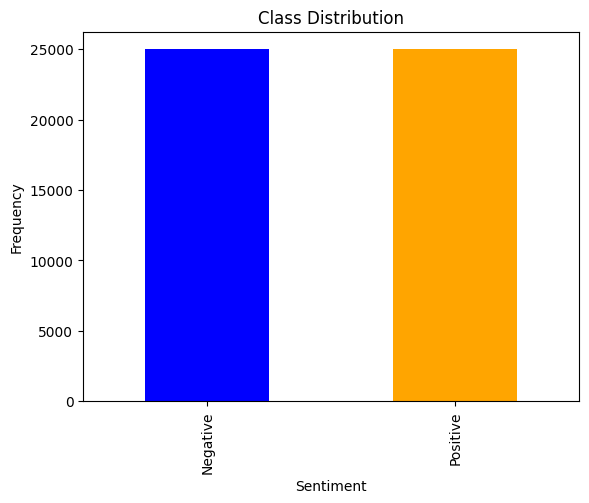

In [ ]:
# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

df['label'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

In [ ]:
# Split the dataset into training, validation, and test sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=0.5, stratify=test['label'])
print(f"Train size: {train.shape[0]}, Validation size: {validation.shape[0]}, Test size: {test.shape[0]}")


Train size: 35000, Validation size: 7500, Test size: 7500


In [ ]:
# 2. Create a DatasetDict
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False)
})

In [ ]:
# 3. Tokenization
from transformers import AutoTokenizer

# Load a pre-trained tokenizer for DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

tokenized_dataset = dataset.map(tokenize, batched=True)


Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [ ]:
# 4. Model Setup
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# Load a pre-trained DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define metrics for evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [ ]:
# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-15-d1a6b1557bfe>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
# 5. Train the Model
trainer.train()

# 6. Evaluate the Model
predictions = trainer.predict(tokenized_dataset['test'])
print(predictions.metrics)


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.204000,0.233009,0.916267,0.920284,0.878149,0.966667
2,0.097600,0.231302,0.934000,0.934774,0.923939,0.945867


{'test_loss': 0.23478184640407562, 'test_accuracy': 0.9348, 'test_f1': 0.9359528487229862, 'test_precision': 0.9196911196911197, 'test_recall': 0.9528, 'test_runtime': 110.1082, 'test_samples_per_second': 68.115, 'test_steps_per_second': 4.259}


In [ ]:
# 7. Save the Model Locally
trainer.save_model("distilbert-base-uncased-sentiment-model")

In [ ]:
import shutil
shutil.make_archive("distilbert-sentiment-model", 'zip', "distilbert-base-uncased-sentiment-model")

'/content/distilbert-sentiment-model.zip'

In [ ]:
# Download the zipped model
from google.colab import files
files.download("distilbert-sentiment-model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
 #Reload the model and tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-sentiment-model")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-sentiment-model")

In [ ]:
# Optional: Move the model to GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# 9. Test Predictions
text_samples = ["This movie was amazing!", "I hated this film.", "It was just okay, nothing special."]
encoded_samples = tokenizer(text_samples, padding=True, truncation=True, return_tensors="pt").to(device)
outputs = model(**encoded_samples)
predicted_classes = outputs.logits.argmax(dim=1)
print(predicted_classes)  # Output: Tensor of predicted labels

tensor([1, 0, 0], device='cuda:0')


In [ ]:
!pip install pyngrok --quiet



In [ ]:
!streamlit run app.py &>/dev/null &


In [ ]:
!ngrok authtoken 2roOBG4LaCAkYzm6bU9ajC7Qz4g_4pH2HHjcnNg9vuaFT1hBn






Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Start ngrok tunnel for port 8501
public_url = ngrok.connect(addr=8501, proto="http")
print(f"Your Streamlit app is available at: {public_url}")


Your Streamlit app is available at: NgrokTunnel: "https://8803-34-125-23-20.ngrok-free.app" -> "http://localhost:8501"
